### New York City Taxi Trip Duration

This is a regression problem which tries to predict the total ride duration of taxi trips in New York City based on pickup time, geo-coordinates, number of passengers, and several other variables. The dataset can be accessed from here: https://www.kaggle.com/c/nyc-taxi-trip-duration/data

#### Importing dependencies

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import math
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split

### Loading and exploring dataset

In [2]:
train_data = pd.read_csv('/my_data/train.csv')    # loading train data
test_data = pd.read_csv('/my_data/test.csv')    # loading train data

In [3]:
train_data.head()  # Let us check out the data
train_data.describe()   # Basic statistics about the dataset

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


The maximum trip duration is 3526282 seconds, that is approx 980 hours and the minimum trip duration is 1 second. But since we will be using RMSLE as our evaluation metric, the outliers will not cause much trouble.
Also the maximum no. of passenger in the vehicle comes out to be 9, which can be considered as an outlier.

In [4]:
print ("Total number of rows in train_data : {}".format(train_data.shape[0]))    #number of rows.
print ("Total number of columns in train_data : {}".format(train_data.shape[1]))   # number of columns
print ("Total missing values : {}".format(train_data.isnull().sum()))         # finding out total number of missing values.

Total number of rows in train_data : 1458644
Total number of columns in train_data : 11
Total missing values : id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


### Data Preprocessing

#### Removing outliers 

Removing outliers from the trip duration variable.

In [5]:
m = np.mean(train_data['trip_duration'])
s = np.std(train_data['trip_duration'])
train_data = train_data[train_data['trip_duration'] <= m + 2*s]
train_data = train_data[train_data['trip_duration'] >= m - 2*s]

Removing outliers from pickup and dropoff coordinates

The boundary of Ney York City comes out as <br/> 

city_long_border = (-74.03, -73.75)        Longitudes <br/r>
city_lat_border = (40.63, 40.85)           Latitudes <br/r>

So we will remove all pickup and dropoff locations that fall outside these coordinates.

In [6]:
train_data = train_data[train_data['pickup_longitude'] <= -73.75]
train_data = train_data[train_data['pickup_longitude'] >= -74.03]
train_data = train_data[train_data['pickup_latitude'] <= 40.85]
train_data = train_data[train_data['pickup_latitude'] >= 40.63]
train_data = train_data[train_data['dropoff_longitude'] <= -73.75]
train_data = train_data[train_data['dropoff_longitude'] >= -74.03]
train_data = train_data[train_data['dropoff_latitude'] <= 40.85]
train_data = train_data[train_data['dropoff_latitude'] >= 40.63]

Removing outlier passenger_count data where the count of passenger more than 6

In [7]:
train_data = train_data[train_data['passenger_count'] <= 6]
test_data = test_data[test_data['passenger_count'] <= 6]

### Feature Extraction

Extracting Datetime features from our train and test date: The total trip duration may depend on the hour of the day, month as well as day of the week. So we will extract these features.

In [8]:
train_data['pickup_datetime'] = pd.to_datetime(train_data.pickup_datetime)
test_data['pickup_datetime'] = pd.to_datetime(test_data.pickup_datetime)
train_data.loc[:, 'pickup_date'] = train_data['pickup_datetime'].dt.date
test_data.loc[:, 'pickup_date'] = test_data['pickup_datetime'].dt.date
train_data['dropoff_datetime'] = pd.to_datetime(train_data.dropoff_datetime)

In [9]:
#Extracting Month
train_data['Month'] = train_data['pickup_datetime'].dt.month
test_data['Month'] = test_data['pickup_datetime'].dt.month

In [10]:
#Extracting Hour
train_data['Hour'] = train_data['pickup_datetime'].dt.hour
test_data['Hour'] = test_data['pickup_datetime'].dt.hour

In [11]:
#Extracting Day of the week
train_data['dayofweek'] = train_data['pickup_datetime'].dt.dayofweek
test_data['dayofweek'] = test_data['pickup_datetime'].dt.dayofweek

#### Extracting distance and directionality features

We can determine the distance and direction of a each trip based on the pickup and dropoff coordinates. Taken from this [post](https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367), For this the following three functions are required:

In [12]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

The three functions given above are for 
1. calculating the haversine distance between any two coordinates. This gives us the great circle distance between any two points on the map.
2. calculating the manhattan distance
3. calculating the directionality ( bearing) of the distance travelled

In [13]:
train_data.loc[:, 'distance_haversine'] = haversine_array(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
test_data.loc[:, 'distance_haversine'] = haversine_array(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)    
    
train_data.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
test_data.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)

train_data.loc[:, 'direction'] = bearing_array(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
test_data.loc[:, 'direction'] = bearing_array(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)

### Handling pickup and dropoff coordinates data

One way to handle the pickup and dropoff coordinates in our train and test data is form clusters of these locations. We can use k-means clustering algorithm to form clusters and then use one hot encoding technique. Here we will be forming 50 clusters.

In [14]:
coords = np.vstack((train_data[['pickup_latitude', 'pickup_longitude']].values,
                    train_data[['dropoff_latitude', 'dropoff_longitude']].values))

In [15]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=50, batch_size=10000).fit(coords[sample_ind])

In [16]:
train_data.loc[:, 'pickup_cluster'] = kmeans.predict(train_data[['pickup_latitude', 'pickup_longitude']])
train_data.loc[:, 'dropoff_cluster'] = kmeans.predict(train_data[['dropoff_latitude', 'dropoff_longitude']])
test_data.loc[:, 'pickup_cluster'] = kmeans.predict(test_data[['pickup_latitude', 'pickup_longitude']])
test_data.loc[:, 'dropoff_cluster'] = kmeans.predict(test_data[['dropoff_latitude', 'dropoff_longitude']])

### Visualizing our dataset

We will first log transform 'trip_duration' as this will take care of the extreme values.

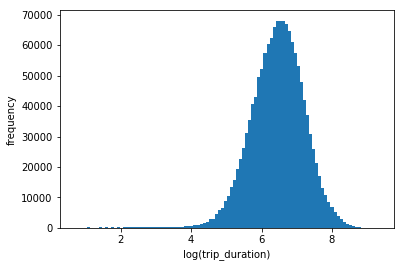

In [17]:
train_data['log_trip_duration'] = np.log(train_data['trip_duration'].values + 1)
plt.hist(train_data['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('frequency')
plt.show()

We see that our target variable is normally distributed, with only a few outliers. Most trips are between e^4 and e^8 seconds i.e most trips are between 1 min and 60 mins long.

Let us see if the pickup_hours, pickup_day affects the speed of the travel.

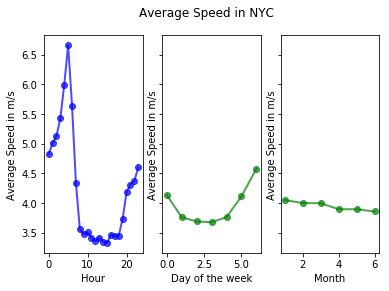

In [18]:
train_data.loc[:, 'avg_speed_h'] = 1000 * train_data['distance_haversine'] / train_data['trip_duration']     # Speed in m/s
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train_data.groupby('Hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train_data.groupby('dayofweek').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train_data.groupby('Month').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour')
ax[1].set_xlabel('Day of the week')
ax[2].set_xlabel('Month')
ax[0].set_ylabel('Average Speed in m/s')
ax[1].set_ylabel('Average Speed in m/s')
ax[2].set_ylabel('Average Speed in m/s')
fig.suptitle('Average Speed in NYC')
plt.show()

We see that the average speed of taxis depends on the hour of pickup and also on the day of the week. As expected the speed is the slowest during the time period 09:00 hrs to 19:00 hrs. Similarly weekdays are the slowest and there is some increase in average speeds during the weekends.
Finally, for the average speed in various months we see that  in the winter months the average speed goes up. This could be because of less traffic in winter months, as a result the average speed goes up.

#### Adding information from additional dataset

We will be usinng the OSRM fastest route data - The fastest routes for each data point is extracted. It contains features like starting_street, end_street, total_distance, total_travel_time, number_of_steps (one step consists of some driving and an action the taxi needs to perform. It can be something like a turn or going on to a highway)
(Source: https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm)


In [19]:
fr1 = pd.read_csv('/my_data/fastest_routes_train_part_1.csv', usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fr2 = pd.read_csv('/my_data/fastest_routes_train_part_2.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train_fastest_route = pd.concat((fr1, fr2))
test_fastest_route = pd.read_csv('/my_data/fastest_routes_train_part_1.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])

train_data = train_data.merge(train_fastest_route, how='left', on='id')
test_data = test_data.merge(test_fastest_route, how='left', on='id')

In [20]:
train_data.dropna(axis=0, how='any', inplace=True)     # dropping NA values

In [21]:
train_data.shape, test_data.shape

((1437127, 25), (625132, 21))

#### Using one hot encoding for handling our categorical variables namely vendor id, passenger count, store_and_fwd_flag, month, DayOfMonth, Hour, DayOfWeek, pickup_cluster, dropoff_cluster 

In [22]:
vendor_train = pd.get_dummies(train_data['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test_data['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(train_data['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_test = pd.get_dummies(test_data['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train_data['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test_data['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
cluster_pickup_train = pd.get_dummies(train_data['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_pickup_test = pd.get_dummies(test_data['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_dropoff_train = pd.get_dummies(train_data['dropoff_cluster'], prefix='d', prefix_sep='_')
cluster_dropoff_test = pd.get_dummies(test_data['dropoff_cluster'], prefix='d', prefix_sep='_')

month_train = pd.get_dummies(train_data['Month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test_data['Month'], prefix='m', prefix_sep='_')
hour_train = pd.get_dummies(train_data['Hour'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test_data['Hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(train_data['dayofweek'], prefix='dow', prefix_sep='_')
dow_test = pd.get_dummies(test_data['dayofweek'], prefix='dow', prefix_sep='_')

Now that we have on-hot encoded our train and test data we can drop the categorical variables

In [23]:
train_data = train_data.drop(['id','vendor_id','passenger_count','pickup_datetime','pickup_date','store_and_fwd_flag','Month','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis = 1)

test_data = test_data.drop(['id','vendor_id','passenger_count','pickup_datetime','pickup_date','store_and_fwd_flag','Month','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis = 1)

train_data = train_data.drop(['dropoff_datetime','avg_speed_h','log_trip_duration'], axis = 1) #dropping log_trip_duration

Lets take a look at our train and test data

In [24]:
train_data.shape,test_data.shape

((1437127, 9), (625132, 8))

We should now add our one hot encoded variables to the train and test datasets

In [25]:
train_final = pd.concat([train_data,vendor_train,passenger_count_train,store_and_fwd_flag_train,cluster_pickup_train,
                          cluster_dropoff_train, month_train,hour_train,dow_train], axis=1)

In [26]:
test_final = pd.concat([test_data,vendor_test,passenger_count_test,store_and_fwd_flag_test,cluster_pickup_test, 
                        cluster_dropoff_test, month_test, hour_test,dow_test], axis=1)

In [27]:
train_final.shape, test_final.shape

((1437127, 157), (625132, 156))

### Splitting train_final further into training set and test set

We should now split the train_final set further into train and test set, this will enable us to tweak model parameters to increase accuracy and help us to avoid overfitting. We will keep the test_final set for our final submission in the kaggle competition.

Before splitting our train_final we need to change the form into the form to X matrix and Y labels, as this form is the required format for inputting into our sklearn algorithm

In [28]:
duration = train_final['trip_duration']                 # Using trip_duration as Y labels
features = train_final.drop('trip_duration', axis=1)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(features, duration, train_size= 0.8, random_state=0)

In [30]:
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)        # print shape of X_train, X_test

(1149701, 156) (287426, 156) (1149701,) (287426,)


#### Establishing performance matrix

In [31]:
def performance_metric(actual, predicted):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
     
   
    assert(len(predicted) == len(actual))
    p = np.log(np.array(predicted) + 1)
    a = np.log(np.array(actual) + 1)
    score = (((p - a)**2).sum() / len(predicted))**0.5

    
    # Return the score
    return score

### Checking the benchmark model

A good benchmark model would be one that is solely based on the distance of the trip divided by the average speed of taxis in city like New York (not taking into account other variables like traffic, road conditions, location etc.) Here we will assume an average speed of 11.5 mph (18.50 kilometer per hour). (source: http://animalnewyork.com/2014/data-reveals-worst-times-traffic-nyc)

In [32]:
pred_benchmark = (X_test['distance_haversine']/18.50)*3600      # trip_duration in seconds

In [33]:
error_benchmark = performance_metric(y_test, pred_benchmark)
print (error_benchmark)

0.755105106805


##  Implementing a Decision Tree Regressor

### Using grid search to find best model

In [72]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def fit_model_DT(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    
    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':[1,2,3,4,5,6,7,8,9,10]} 

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    grid = GridSearchCV(regressor, param_grid=params, scoring=scoring_fnc)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [73]:
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor(max_depth=10)
reg.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

#### Optimal Model

In [74]:
# Fit the training data to the model using grid search
reg = fit_model_DT(X_train, y_train)

# Produce the value for 'max_depth'
print ("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 1 for the optimal model.


##### Calculating our predicition on test data and RMSLE error

In [75]:
prediction = reg.predict(X_test)
error_test = performance_metric(y_test, prediction)
print (error_test)

0.667422700392


### Implementing Random Forest Regressor

Using grid search to find best model

In [34]:
from sklearn.ensemble import RandomForestRegressor


In [35]:
rfr = RandomForestRegressor(max_depth =10, random_state = 99)
rfr.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=99,
           verbose=0, warm_start=False)

In [36]:
prediction = rfr.predict(X_test)
error_test = performance_metric(y_test, prediction)
print (error_test)

0.444008113157


The RMSLE error using the Random Forest Regressor algorithm comes out to be 0.4440

### Results

#### Visualizing most important features

In [40]:
# Extracting the feature importances using .feature_importances_ 
featureimp = features.columns

In [43]:
imp_features_sorted = sorted(zip(map(lambda x: round(x, 4), rfr.feature_importances_), featureimp), 
             reverse=True)

In [45]:
from pprint import pprint
print ("Features sorted by their score:")
pprint (imp_features_sorted)


Features sorted by their score:
[(0.7379, 'total_travel_time'),
 (0.1694, 'total_distance'),
 (0.0149, 'distance_haversine'),
 (0.0083000000000000001, 'dow_6'),
 (0.0077999999999999996, 'direction'),
 (0.0071999999999999998, 'h_16'),
 (0.0067000000000000002, 'h_15'),
 (0.0060000000000000001, 'h_17'),
 (0.0041000000000000003, 'h_6'),
 (0.0035000000000000001, 'h_14'),
 (0.0028, 'h_7'),
 (0.0025999999999999999, 'dow_5'),
 (0.0022000000000000001, 'distance_dummy_manhattan'),
 (0.0020999999999999999, 'dropoff_cluster'),
 (0.0020999999999999999, 'd_22'),
 (0.0018, 'h_18'),
 (0.0016999999999999999, 'h_0'),
 (0.0015, 'h_1'),
 (0.0014, 'd_3'),
 (0.0011999999999999999, 'h_8'),
 (0.0011000000000000001, 'h_2'),
 (0.00089999999999999998, 'number_of_steps'),
 (0.00080000000000000004, 'm_6'),
 (0.00080000000000000004, 'h_23'),
 (0.00080000000000000004, 'h_13'),
 (0.00080000000000000004, 'd_4'),
 (0.00069999999999999999, 'd_25'),
 (0.00059999999999999995, 'm_5'),
 (0.00059999999999999995, 'h_5'),
 (0.

In [69]:
top10 = imp_features_sorted[:10]
print (top10)

[(0.7379, 'total_travel_time'), (0.1694, 'total_distance'), (0.0149, 'distance_haversine'), (0.0083000000000000001, 'dow_6'), (0.0077999999999999996, 'direction'), (0.0071999999999999998, 'h_16'), (0.0067000000000000002, 'h_15'), (0.0060000000000000001, 'h_17'), (0.0041000000000000003, 'h_6'), (0.0035000000000000001, 'h_14')]


In [70]:
temp = []
temp2 = []
for a in range(10):
    temp.append(top10[a][0])
    temp2.append(top10[a][1])

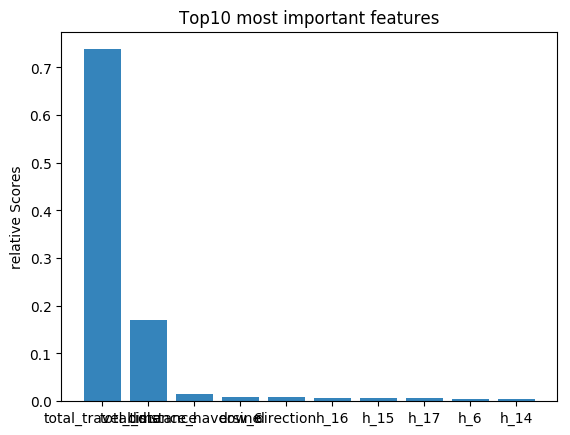

In [71]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
  
pos = np.arange(len(temp2))    
plt.bar(pos, temp, align='center', alpha=0.9)
plt.xticks(pos, temp2)
plt.ylabel('relative Scores')
plt.title('Top10 most important features')
 
plt.show()